# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

In [ ]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [ ]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [ ]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [ ]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [3]:
import math

eps = 10 ** (-14)

def removeVerticalLines(lines):
    for i in range(len(lines)):
        if isVertical(lines[i]):
            lines.pop(i)

def isVertical(line):
    if line[0][0] == line[1][0]:
        return True
    else:
        return False

def removeCloseLines(lines):
    for i in range(len(lines) - 1, -1, -1):
        if isClose(lines, i):
            lines.pop(i)
            
def isClose(lines, i):
    for j in range(len(lines)):
        if i == j:
            continue
        if dist(lines[j][0], lines[i][0]) < eps or dist(lines[j][0], lines[i][1]) < eps\
        or dist(lines[j][1], lines[i][0]) < eps or dist(lines[j][1], lines[i][1]) < eps:
            return True
    return False

def dist(A, B):
    dx = A[0] - B[0]
    dy = A[1] - B[1]
    return math.sqrt(dx * dx + dy * dy)

linesSets = [None, None]

### Interaktywne wprowadzanie odcinków

<IPython.core.display.Javascript object>


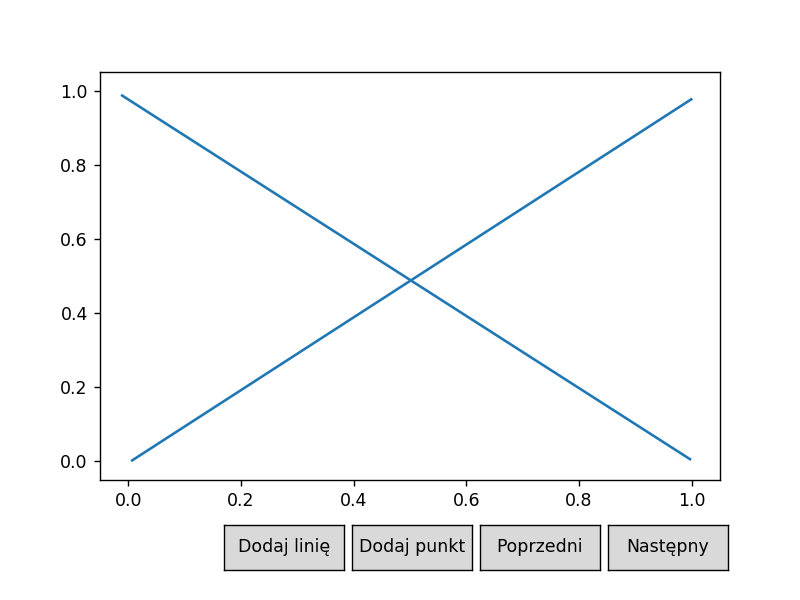

In [4]:
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [5]:
plot2 = Plot([plot1.get_added_elements()])
    
data = js.loads(plot2.toJson())
lines = []
if data and data[0] and data[0]["lines"]:
    for line in data[0]["lines"][0]:
        lines.append(line)
    
removeVerticalLines(lines)
removeCloseLines(lines)
linesSets[0] = lines
enScene = Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'blue')])

# Zapis do pliku
# with open('enteredLines.json', 'w') as file:
#     file.write(Plot([enScene]).toJson())

### Generowanie losowych odcinków

In [6]:
import random

xmin = 0
ymin = 0
xmax = 10
ymax = 10
num = 10

lines = []
for i in range(num):
    while(True):
        A = [random.uniform(xmin, xmax), random.uniform(xmin, xmax)]
        B = [random.uniform(xmin, xmax), random.uniform(xmin, xmax)]
        lines.append([A, B])
        if isVertical(lines[i]) or isClose(lines, i):
            lines.pop(i)
        else:
            break

removeVerticalLines(lines)
removeCloseLines(lines)
linesSets[1] = lines
ranScene = Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'green')])

# Zapis do pliku
# with open('generatedLines.json', 'w') as file:
#     file.write(Plot([ranScene]).toJson())

### Wizualizacja zbiorów odcinków

<IPython.core.display.Javascript object>


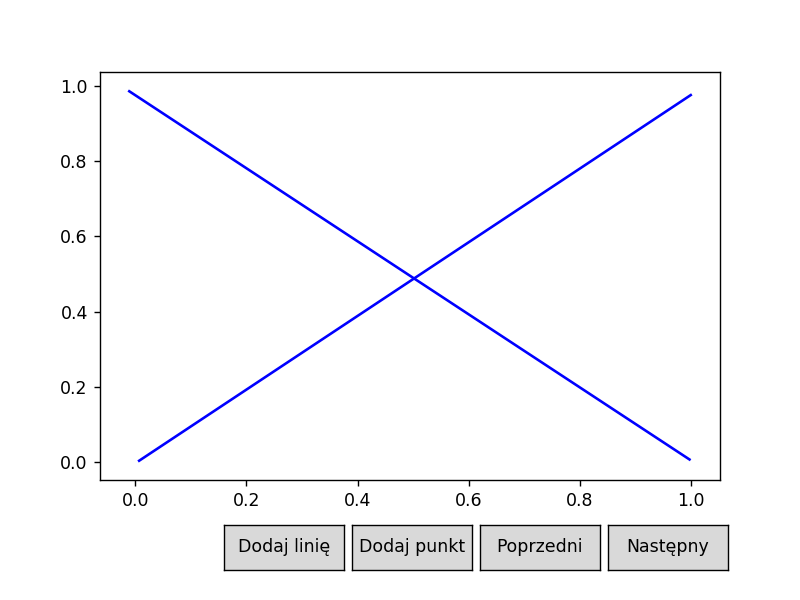

In [7]:
%matplotlib notebook

scenes = []
scenes.append(enScene)    
scenes.append(ranScene)

######### Ewentualne odczytanie z pliku ######################################################
# with open('lines.json', 'r') as file:
#     data = file.read()
# data = js.loads(data)
# lines = []
# for line in data[0]["lines"][0]:
#     lines.append(line)
    
# removeVerticalLines(lines)
# removeCloseLines(lines)
# linesSets.append(lines)
# fileScene = Scene([PointsCollection()], [LinesCollection([lines[i] for i in range(len(lines))], color = 'red')])
# scenes.append(fileScene)
###############################################################################################

plot = Plot(scenes)
plot.draw()

### Funkcje pomocnicze

In [8]:
eps = 10 ** (-14)

def det(A, B, C):
    return A[0]*B[1] + B[0]*C[1] + C[0]*A[1] - C[0]*B[1] - A[0]*C[1] - B[0]*A[1]

def orient(A, B, C):
    d = det(A, B, C)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0
    
def onSegment(A, B, C):
    if orient(A, B, C) != 0:
        return false
    if C[0] <= max(A[0], B[0]) and C[0] >= min(A[0], B[0]) and C[1] <= max(A[1], B[1]) and C[1] >= min(A[1], B[1]):
        return true
    else:
        return false

def doIntersect(seg1, seg2):
    A = seg1[0]
    B = seg1[1]
    C = seg2[0]
    D = seg2[1]
    o1 = orient(A, B, C)
    o2 = orient(A, B, D)
    o3 = orient(C, D, A)
    o4 = orient(C, D, B)
    
    if o1 != o2 and o3 != o4:
        return True
#     elif o1 == 0 and onSegment(A, B, C):
#         return True
#     elif o2 == 0 and onSegment(A, B, D):
#         return True
#     elif o3 == 0 and onSegment(C, D, A):
#         return True
#     elif o4 == 0 and onSegment(C, D, B):
#         return True
    else:
        return False
    
def findIntersection(seg1, seg2):
    if not doIntersect(seg1, seg2):
        return 0
    
    A = seg1[0]
    B = seg1[1]
    C = seg2[0]
    D = seg2[1]
    
    a1 = (A[1] - B[1]) / (A[0] - B[0])
    b1 = A[1] - a1 * A[0]
    a2 = (C[1] - D[1]) / (C[0] - D[0])
    b2 = C[1] - a1 * C[0]

    x0 = (b2 - b1) / (a1 - a2)
    y0 = a1 * x0 + b1
    
    return [x0, y0]

def prepareLines(lines):
    for line in lines:
        A = line[0]
        B = line[1]
        if A[0] > B[0]:
            (A, B) = (B, A)

### Struktury danych

In [9]:
import heapq

### Pierwszy algorytm zamiatania

In [10]:
# Funkcja wstawiająca lub usuwająca odcinki ze struktury stanu T. Funkcja zwraca sąsiadów do sprawdzenia, czy się przecinają
def insertToT(T, i, C, lines):
    if not T:
        T.append(i)
        return []
    if C == lines[i][0]:  # Początek odcinka
        j = 0
        A = lines[T[j]][0]
        B = lines[T[j]][1]
        while j < len(T) and orient(A, B, C) == -1:
            j += 1
        T.insert(j, i)
        result = []
        if j > 0:
            result.append((T[j-1], T[j]))
        if j < len(T) - 1:
            result.append((T[j], T[j+1]))
        return result
    else: # Koniec odcinka
        j = T.index(i)
        T.pop(j)
        result = []
        if j < len(T) and j >= 0:
            result.append((T[j-1], T[j]))
        return result

In [11]:
# Algorytm sprawdzający, czy choć jedna para odcinków w zadanym zbiorze się przecina
def doAnyIntersect(lines):
    prepareLines(lines)
    T = []
    Q = []
    for i in range(len(lines)):
        A = lines[i][0]
        B = lines[i][1]
        heapq.heappush(Q, (A[0], i))
        heapq.heappush(Q, (B[0], i))

    while Q:
        (x, i) = heapq.heappop(Q)
        if x == lines[i][0][0]:
            C = lines[i][0]
        else:
            C = lines[i][1]
        toCheck = insertToT(T, i, C, lines)
        for el in toCheck:
            seg1 = lines[el[0]]
            seg2 = lines[el[1]]
            if doIntersect(seg1, seg2):
                print(findIntersection(seg1, seg2))
                return True
    return False

In [12]:
print(doAnyIntersect(linesSets[0]))

[0.4963630302501731, 0.49310325740184535]
True
